## Import Libraries

In [1]:
#IMPORT needed libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
import math
import pickle
import os
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
from tqdm import tqdm
import random
%matplotlib inline


## Import Image Data

In [2]:
#IMPORT all needed data
car_images_filenames = glob.glob("vehicles/*/*.*")
noncar_images_filenames = glob.glob("non-vehicles/*/*.*")
test_images_filenames = glob.glob("test_images/*.*")
print("There are ", len(car_images_filenames), "Car Images")
print("There are ", len(noncar_images_filenames), "Non-Car Images")
print("There are ", len(test_images_filenames), "Test Images")

car_images = []
noncar_images = []
test_images = []

for filename in car_images_filenames:
    car_images.append(mpimg.imread(filename))
for filename in noncar_images_filenames:
    noncar_images.append(mpimg.imread(filename))
for filename in test_images_filenames:
    test_images.append(mpimg.imread(filename))
car_images = np.asarray(car_images)
noncar_images = np.asarray(noncar_images)
test_images = np.asarray(test_images)

print(car_images.shape)
print(noncar_images.shape)
print(test_images.shape)



There are  8792 Car Images
There are  8968 Non-Car Images
There are  6 Test Images
(8792, 64, 64, 3)
(8968, 64, 64, 3)
(6, 720, 1280, 3)


## Show 50 random images from car / noncar images

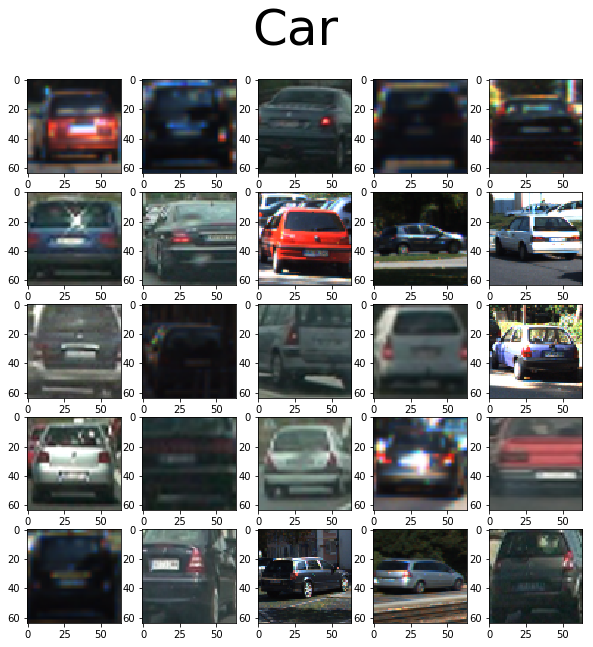

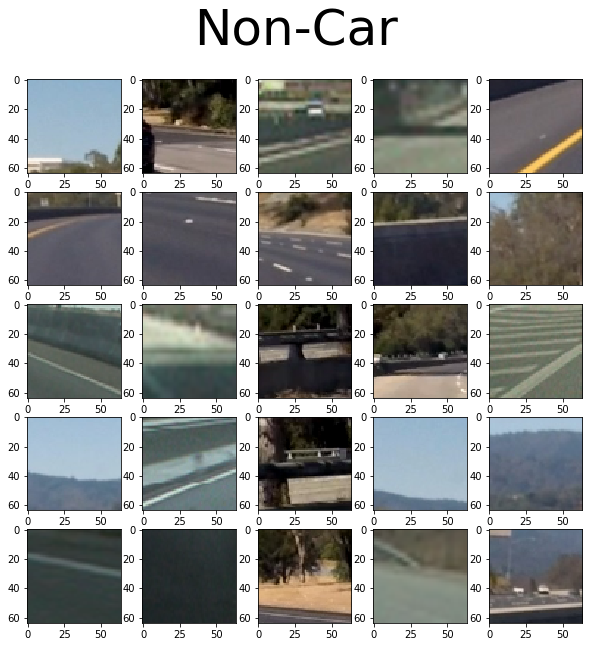

In [3]:
examples = plt.figure()
examples.set_figwidth(10)
examples.set_figheight(10)
examples.suptitle('Car', fontsize=50)
for i in range(25):
    img = examples.add_subplot(5, 5, i + 1)
    image = car_images[random.randint(0,len(car_images) - 1)].squeeze()
    img.imshow(image)
examples = plt.figure()
examples.set_figwidth(10)
examples.set_figheight(10)
examples.suptitle('Non-Car', fontsize=50)
for i in range(25):
    img = examples.add_subplot(5, 5, i + 1)
    image = noncar_images[random.randint(0,len(noncar_images) - 1)].squeeze()
    img.imshow(image)

## HOG Function

In [4]:
def hog_process(img, orient, pix_per_cell, cell_per_block, 
                        visualise=False, feature_vec=False):
    #CHECK to see if we want to visualise and send two outputs if yes, one if no
    if visualise == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

## Test HOG Function

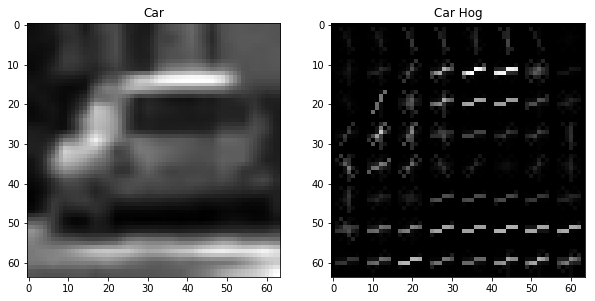

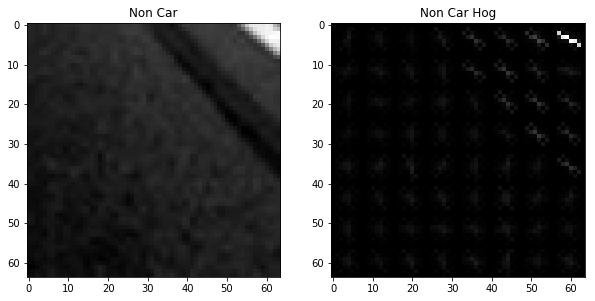

In [5]:
#HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

ind = np.random.randint(0, car_images.shape[0])
car_image = car_images[ind]
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
features, carhog_image = hog_process(car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        visualise=True, feature_vec=False)
ind = np.random.randint(0, noncar_images.shape[0])
noncar_image = noncar_images[ind]
noncar_gray = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2GRAY)
features, noncarhog_image = hog_process(noncar_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        visualise=True, feature_vec=False)
# Plot the examples
fig = plt.figure(figsize = (10, 10))
plt.subplot(121)
plt.imshow(car_gray, cmap='gray')
plt.title('Car')
plt.subplot(122)
plt.imshow(carhog_image, cmap='gray')
plt.title('Car Hog')

fig = plt.figure(figsize = (10, 10))
plt.subplot(121)
plt.imshow(noncar_gray, cmap='gray')
plt.title('Non Car')
plt.subplot(122)
plt.imshow(noncarhog_image, cmap='gray')
plt.title('Non Car Hog')

## Define image processing functions

In [6]:
def convert_cs(image, cs_out='RGB', size=(32,32)):
    if cs_out != 'RGB':
        if cs_out == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cs_out == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cs_out == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cs_out == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cs_out == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)
    return feature_image

def bin_spatial(img, size=(32,32)):
    return cv2.resize(img, size).ravel()

def color_hist(img, nbins=32, bins_range=(0, 256)):
    c1h = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    c2h = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    c3h = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((c1h[0], c2h[0], c3h[0]))
    return hist_features

def extract_features(img, cs_out='YCrCb', size=(32,32), nbins=32, orient=9, pix_per_cell = 8,
                     cell_per_block=2, bins_range=(0,256), bin_enable = True, hist_enable = True,
                     hog_enable = True, hog_channelselect = 0):
    features = []
    image = convert_cs(img, cs_out)
    
    if bin_enable == True:
        bin_features = bin_spatial(image)  
        features.append(bin_features)
        #print("cs_features")
        #print(cs_features.shape)
        
    if hist_enable == True:
        hist_features = color_hist(image, nbins, bins_range)
        features.append(hist_features)
        #print("features after hist append")
        #print(features.shape)
        #print("hist_features")
        #print(hist_features.shape)
        
    if hog_enable == True:
        if hog_channelselect == 'ALL':
            hog_feats = []
            for channel in range(image.shape[2]): #Possibly get rid of range
                hog_feats.append(hog_process(image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    visualise=False, feature_vec=True))
                hog_features = np.ravel(hog_feats)
        else:
                hog_features = hog_process(image[:,:,hog_channelselect], 
                                    orient, pix_per_cell, cell_per_block, 
                                    visualise=False, feature_vec=True)
        #print("hog_features")
        #print(hog_features.shape)
        features.append(hog_features.flatten())
        
    #print("features after hog flatten")
    #print(hist_features.shape)
    #print(hog_features.shape)
    #print(bin_features.shape)
    #print(features.shape)
    #print("features_file")
    #print(features_file)
    #features = np.asarray(features)
    #print(features_file.shape)
    #features = features.reshape(features.shape[1])
        #print(features_file.shape)
        #print("")
    #print(features.shape)
    #c1h, c2h, c3h, bin_centers, hist_features = color_hist(cs_out, nbins=32, bins_range=(0,256))
    return np.concatenate(features)

## Tunables

In [110]:
cs_out='LUV'
size=(32,32)
nbins=128
orient=9
pix_per_cell = 8
cell_per_block=2
bins_range=(0,256)
bin_enable = True
hist_enable = True
hog_enable = True
hog_channelselect = 'ALL'
heat_threshold = 7

## Extract Features for arrays

In [99]:
#car_features = extract_features(car_images, hog_feat=True)
#notcar_features = extract_features(noncar_images, hog_feat=True)
#car_features = []
#noncar_features = []
'''
for image in car_images:
    image = extract_features(image)
    car_features.append(image)
for image in noncar_images:
    image = extract_features(image)
    noncar_features.append(image)
'''

car_features = []
noncar_features = []

for image in car_images:
    features = extract_features(image, cs_out=cs_out, size=size, nbins=nbins, orient=orient, pix_per_cell = pix_per_cell,
                     cell_per_block=cell_per_block, bins_range=bins_range, bin_enable = bin_enable, hist_enable = hist_enable,
                     hog_enable = hog_enable, hog_channelselect = hog_channelselect)
    car_features.append(features)
for image in noncar_images:
    features = extract_features(image, cs_out=cs_out, size=size, nbins=nbins, orient=orient, pix_per_cell = pix_per_cell,
                     cell_per_block=cell_per_block, bins_range=bins_range, bin_enable = bin_enable, hist_enable = hist_enable,
                     hog_enable = hog_enable, hog_channelselect = hog_channelselect)
    noncar_features.append(features)
car_features = np.asarray(car_features)
noncar_features = np.asarray(noncar_features)
print(car_features.shape)
print(noncar_features.shape)
#print(car_features[1])
#print(car_features[2])
print("Finished loading data")

(8792, 8748)
(8968, 8748)
Finished loading data


## Train SVC

In [100]:
X = np.vstack((car_features, noncar_features))
#print(X.shape)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
scaled_X, y = shuffle(scaled_X, y)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                    test_size=0.2)
# Use a linear SVC
svc = LinearSVC(C=0.003, dual=False, max_iter=5)
svc.fit(X_train, y_train)
print('Using:', orient, 'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8748


## Test SVC

In [101]:
print('Test Accuracy of SVC: {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
print()
print('  Predictions:', svc.predict(X_test[0:200]))
print('       Labels:', y_test[0:20])
print()


Test Accuracy of SVC: 98.87%

  Predictions: [ 0.  0.  1.  1.  1.  1.  0.  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.
  0.  0.  1.  0.  1.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  0.  0.  1.  1.  1.  0.  0.
  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.
  0.  1.  0.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.
  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.
  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.
  0.  0.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0.  1.  1.  0.  1.
  1.  1.  0.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  1.  0.
  1.  0.]
       Labels: [ 0.  0.  1.  1.  1.  1.  0.  0.  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.
  0.  0.]



##  Sliding Window

In [30]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64), interpolation=cv2.INTER_LINEAR)      
        #test_img = (np.sqrt(test_img.astype(np.float32)/255)*255).astype(np.uint8)
        # Extract features for that window using single_img_features()
        features = extract_features(test_img, cs_out=cs_out, size=size, nbins=nbins, orient=orient, pix_per_cell = pix_per_cell,
                     cell_per_block=cell_per_block, bins_range=bins_range, bin_enable = bin_enable, hist_enable = hist_enable,
                     hog_enable = hog_enable, hog_channelselect = hog_channelselect)
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # Return windows for positive detections
    return on_windows


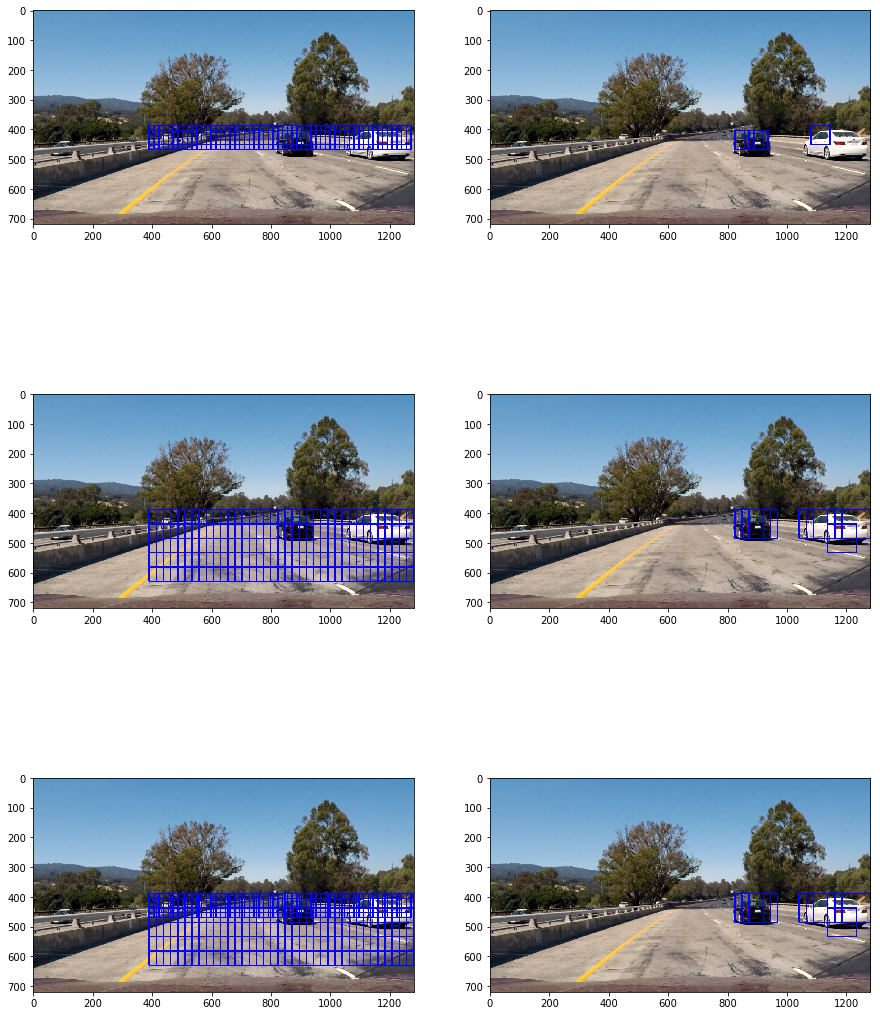

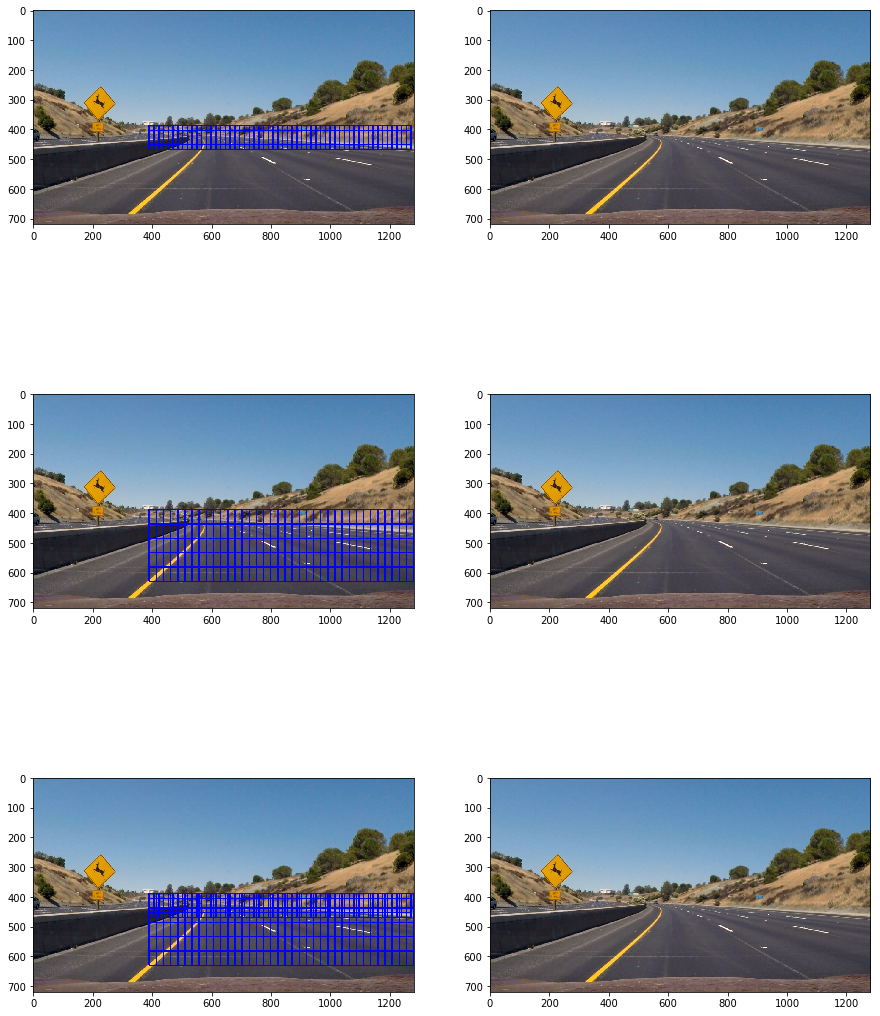

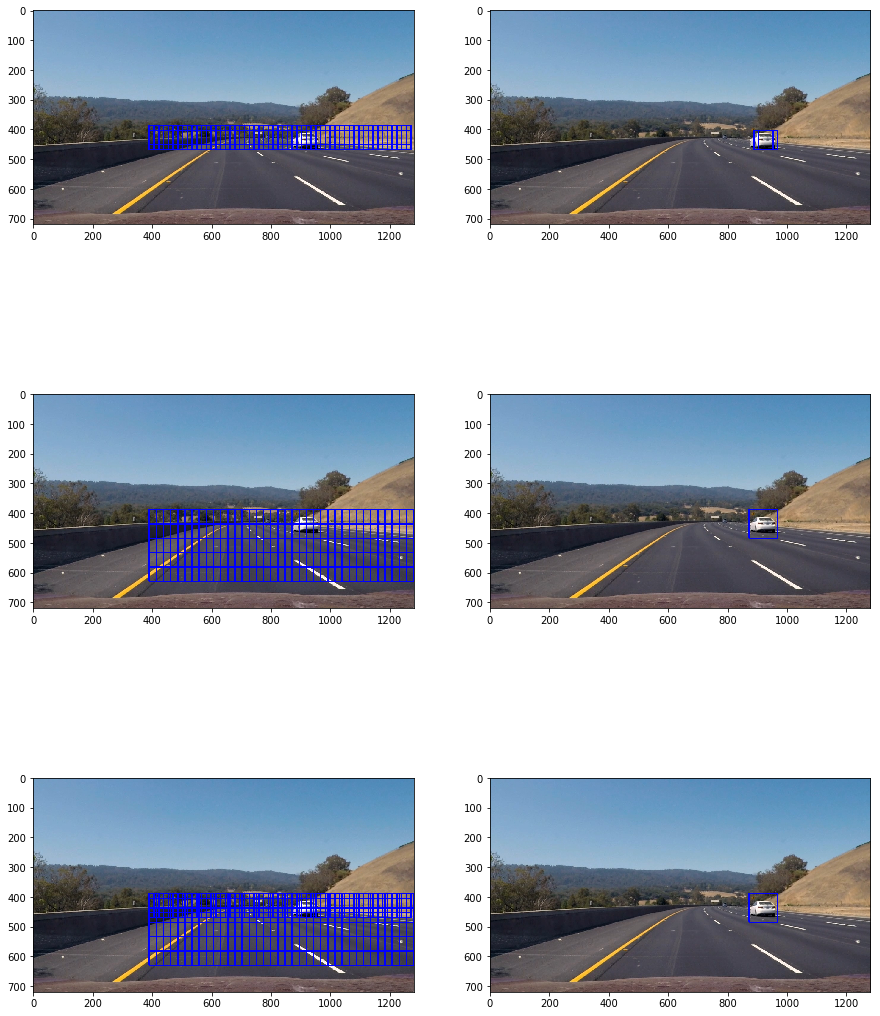

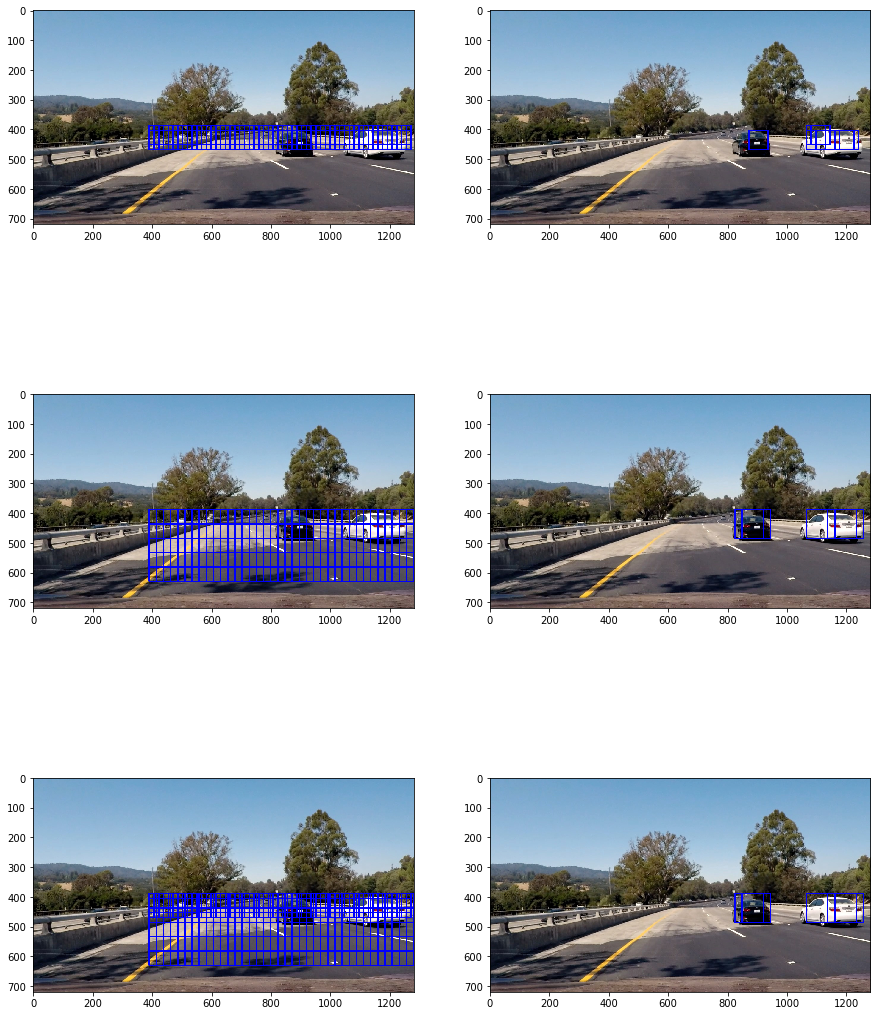

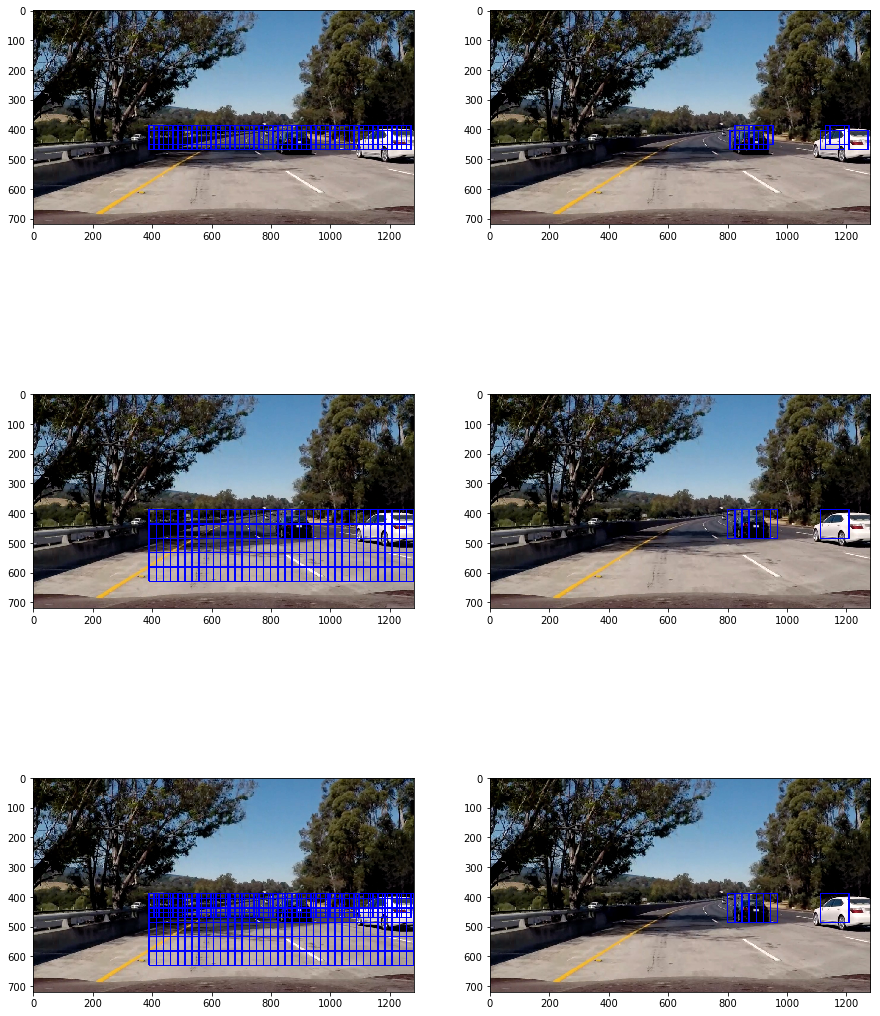

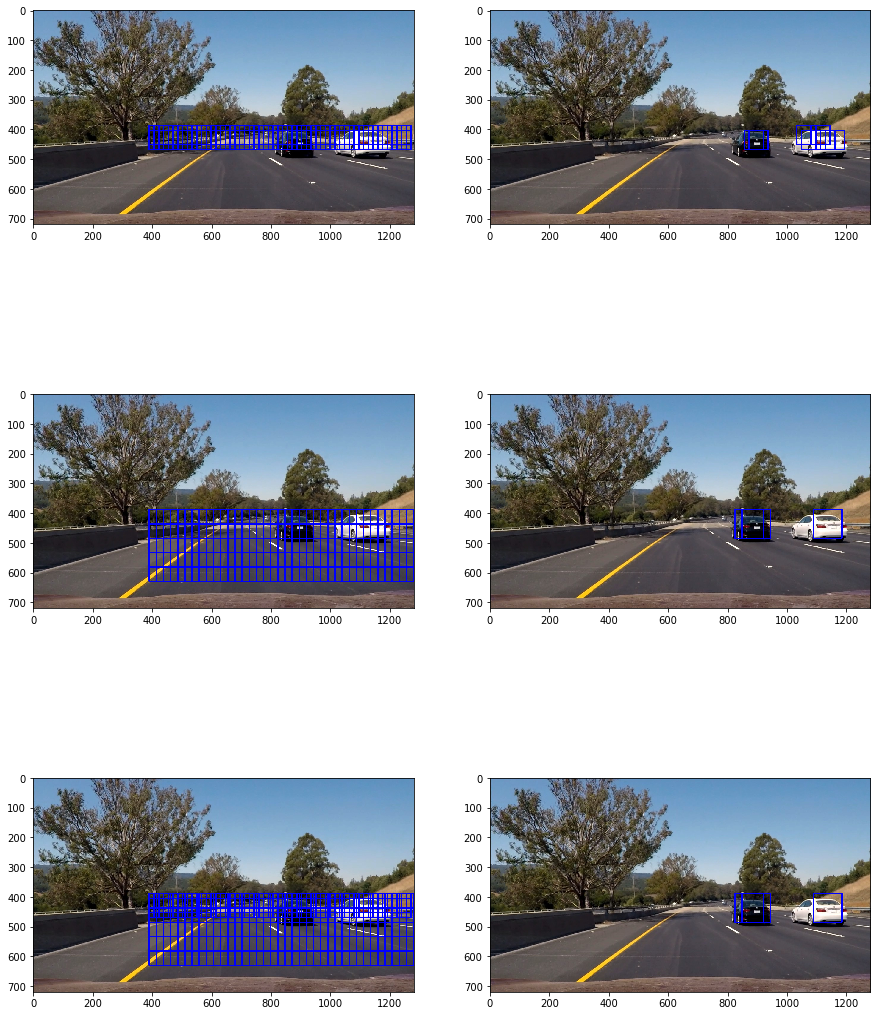

In [102]:

for image in test_images:
    img = np.copy(image)
    img = img.astype(np.float32)/255
    windows = [0,0]
    windows[0] = slide_window(img, x_start_stop=[390, 1280], y_start_stop=[390, 480], 
                        xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    windows[1] = slide_window(img, x_start_stop=[390, 1280], y_start_stop=[390, 650], 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.5))
    rects = []
    rects.append(windows[0])
    rects.append(windows[1])
    rectangles = [item for sublist in rects for item in sublist] 

    f, ax = plt.subplots(3,2, figsize=(15,20))
    t=time.time()
    for i in range(2):
        out_img = draw_boxes(image, windows[i], color=(0, 0, 255), thick=3)
        ax[i][0].imshow(out_img)
        hot_windows = search_windows(img, windows[i], svc, X_scaler, color_space=cs_out, 
                                     spatial_size=size, hist_bins=nbins, 
                                     hist_range=bins_range, orient=orient, 
                                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                     hog_channel=hog_channelselect, spatial_feat=bin_enable, 
                                     hist_feat=hist_enable, hog_feat=hog_enable)
        out_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=3)
        ax[i][1].imshow(out_img)

    out_img = draw_boxes(image, rectangles, color=(0, 0, 255), thick=3)
    ax[2][0].imshow(out_img)
    hot_windows = search_windows(img, windows[i], svc, X_scaler, color_space=cs_out, 
                                     spatial_size=size, hist_bins=nbins, 
                                     hist_range=bins_range, orient=orient, 
                                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                     hog_channel=hog_channelselect, spatial_feat=bin_enable, 
                                     hist_feat=hist_enable, hog_feat=hog_enable)
    out_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=3)
    ax[2][1].imshow(out_img)

## Heat Mapping

In [35]:
#Add Heat Function
def add_heat(image, bbox_list, heatmap = None):
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
#Function for applying threshold to heat map
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

'''def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    #center_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if (((bbox[1][0]-bbox[0][0]) >= 16)and((bbox[1][1]-bbox[0][1]) >= 16)):
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        x_center = (bbox[1][0]+bbox[0][0])/2
        y_center = (bbox[1][1]+bbox[0][1])/2
        #center_list.append((x_center, y_center))
    # Return the image
    return img
    #return img, center_list
'''
#Function to draw the final labeled boxes
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 8)
    # Return the image
    return img
#Split image color channels
def split_channels(image):
    c1 = image[:,:,0]
    c2 = image[:,:,1] 
    c3 = image[:,:,2]
    return c1, c2, c3
#Main final pipeline to discover and test car images
def find_cars(image, cs_out, xstart, xstop, ystart, ystop, scale,
              svc, X_scaler, orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):
    rectangles = []
    img = np.copy(image)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_cs(img_tosearch, cs_out)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, 
                                     (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    #t=time.time()
    hog1 = hog_process(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = hog_process(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = hog_process(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #print(round(time.time()-t, 5), 'Seconds to process one hog')
    for xb in range(nxsteps):
        for yb in range(nysteps):
            newfeatures = []
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Get color features
            if bin_enable == True:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                newfeatures.append(spatial_features)
            if hist_enable == True: 
                hist_features = color_hist(subimg, nbins=hist_bins)
                newfeatures.append(hist_features)            
            if hog_enable == True:
                newfeatures.append(hog_features)
            features = np.concatenate(newfeatures)
            # Scale features and make a prediction
            #print(features)
            test_features = X_scaler.transform(features.reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                #print("test prediction = 1")
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left+xstart, ytop_draw+ystart),
                                  (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart))) 
    return rectangles

## Car Finding Pipeline, feed in one image at a time

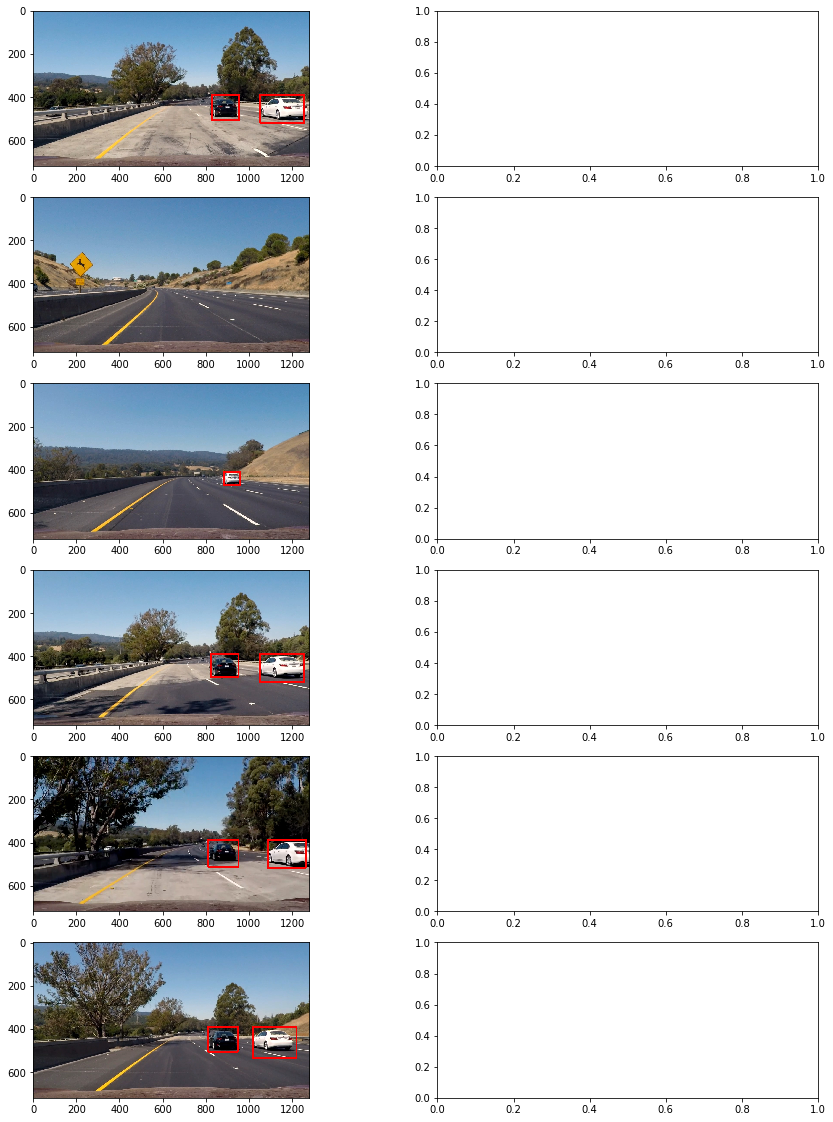

In [115]:
def process_image(image):
    
    xstart = 390
    xstop = image.shape[1]
    #print(xstop)
    y1start = 390
    y1stop = 480
    y1scale = 0.8
    y2start = 390
    y2stop = 650
    y2scale = 1.5
    y3start = 390
    y3stop = 710
    y3scale = 2.0
    
    box_list = []
    box_list.append(find_cars(image, cs_out, xstart, xstop, y1start, y1stop, y1scale,
              svc, X_scaler, orient, pix_per_cell, cell_per_block,
              size, nbins))
    box_list.append(find_cars(image, cs_out, xstart, xstop, y2start, y2stop, y2scale,
              svc, X_scaler, orient, pix_per_cell, cell_per_block,
              size, nbins))
    box_list.append(find_cars(image, cs_out, xstart, xstop, y3start, y3stop, y3scale,
              svc, X_scaler, orient, pix_per_cell, cell_per_block,
              size, nbins))
    #print(box_list)
    
    box_list = [item for sublist in box_list for item in sublist]
    heat = add_heat(image, box_list)
    heat = apply_threshold(heat, heat_threshold)  

    labels = label(heat)
    #box_blank = draw_labeled_bboxes(np.zeros_like(image[:,:,0]).astype(np.float), labels)
    new_img = draw_labeled_bboxes(np.copy(image), labels)
    return new_img

i = 0
f, ax = plt.subplots(6,2, figsize=(15,20))
for image in test_images:
    final = process_image(image)
    ax[i][0].imshow(final)
    #ax[i][1].imshow(heat, cmap='gray')
    i += 1

print()

## Video Processing

In [104]:
'''project_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(project_output, audio=False)
'''

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [01:24<00:02,  2.27s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 1min 22s, sys: 1.73 s, total: 1min 24s
Wall time: 1min 25s


In [37]:
project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [44:19<00:02,  2.18s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 43min 24s, sys: 1min 6s, total: 44min 31s
Wall time: 44min 19s


## Include Lane Finding

In [116]:
def gray(image):
    grayed_image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    return grayed_image
calibration_images = []

for filename in os.listdir("camera_cal/"):
    filename = "camera_cal/" + filename
    image = mpimg.imread(filename)
    #print('This image is:', type(image), 'with dimensions:', image.shape, '/n')
    #plt.figure()
    #plt.imshow(image)
    calibration_images.append(image)
calibration_array = np.asarray(calibration_images)    

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
undistorted_images = []

for image in calibration_images:
    grayed = gray(image)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(grayed, (9,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(grayed,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(image, (9,6), corners2,ret)
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        #plt.figure()
        #plt.imshow(img)

#CALIBRATE Camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, grayed.shape[::-1],None,None)
    
#print('The undistorted image array consists of ', undistorted_array.shape[0], ' images with shape ', undistorted_array.shape[1:3])

#USE pickle to save calibration results
cal_pickle = {}
cal_pickle["mtx"] = mtx
cal_pickle["dist"] = dist
pickle.dump( cal_pickle, open( "calibration.p", "wb"))
print("Wrote Calibration data to calibration.p!")

calibration_array = np.asarray(calibration_images)

#CALIBRATE camera images


criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
undistorted_images = []

for image in calibration_images:
    grayed = gray(image)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(grayed, (9,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(grayed,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(image, (9,6), corners2,ret)
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        #plt.figure()
        #plt.imshow(img)

#CALIBRATE Camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, grayed.shape[::-1],None,None)

for image in calibration_images:
    h,  w = image.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    # undistort
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    '''
    # crop the image
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]
    '''
    #plt.figure()
    #plt.imshow(dst)
    undistorted_images.append(dst)

undistorted_array = np.asarray(undistorted_images)
    
#print('The undistorted image array consists of ', undistorted_array.shape[0], ' images with shape ', undistorted_array.shape[1:3])

#USE pickle to save calibration results
cal_pickle = {}
cal_pickle["mtx"] = mtx
cal_pickle["dist"] = dist
pickle.dump( cal_pickle, open( "calibration.p", "wb"))
print("Wrote Calibration data to calibration.p!")

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def luv_select(img, thresh=(0, 255)):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    l_channel = luv[:,:,0]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

def lab_select(img, thresh=(0, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    binary_output = np.zeros_like(b_channel)
    binary_output[(b_channel > thresh[0]) & (b_channel <= thresh[1])] = 1
    return binary_output



def perspective_transform(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[img_size[0] * 0.5 - 60.0, img_size[1] * 0.5 + 102.0],
                    [img_size[0] * 0.17 + 35.0, img_size[1]],
                    [img_size[0] * 0.83  + 75.0, img_size[1]],
                    [img_size[0] * 0.5 + 70.0, img_size[1] * 0.5 + 102.0]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[(img_size[0] * 0.25), 0],
                    [(img_size[0] * 0.25), img_size[1]],
                    [(img_size[0] * 0.75), img_size[1]],
                    [(img_size[0] * 0.75), 0]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    
    Mrev = cv2.getPerspectiveTransform(dst, src)
    return warped, M, Mrev, src, dst

def sliding_window(binary_warped):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, out_img

def draw_image(undistorted_image, perspective_image, left_fitx, right_fitx, ploty, perspective_Mrev):
    #print(undistorted_image.shape)
    undistorted_zero = np.zeros_like(undistorted_image).astype(np.uint8)
    undistorted_color = undistorted_zero
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print(undistorted_color.shape)
    cv2.fillPoly(undistorted_color, np.int_([pts]), (0, 255, 0))
    new_undistorted = cv2.warpPerspective(undistorted_color, perspective_Mrev, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    result = cv2.addWeighted(undistorted_image, 1, new_undistorted, 0.3, 0)
    # Put text on an image
    #font = cv2.FONT_HERSHEY_SIMPLEX
    #text = "Radius of Curvature: {} m".format(int(curvature))
    #cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    # Find the position of the car
    #pts = np.argwhere(newwarp[:,:,1])
    #position = find_position(pts)
    #if position < 0:
    #    text = "Vehicle is {:.2f} m left of center".format(-position)
    #else:
    #    text = "Vehicle is {:.2f} m right of center".format(position)
    #cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    return result

def write_on_image(final_image, left_curverad, right_curverad):
    curvature = ((left_curverad + right_curverad) / 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(final_image,text,(400,100), font, 1,(255,255,255),2)
    return final_image



Wrote Calibration data to calibration.p!
Wrote Calibration data to calibration.p!


In [108]:
def process_image_with_lanes(image):
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    perspective_image, perspective_M, perspective_Mrev, src, dst = perspective_transform(undistorted_image, mtx, dist)
    #Perform manipulations on new perspective image
    grayed_image = gray(perspective_image)
    gradx = abs_sobel_thresh(perspective_image, orient='x', thresh_min=10 ,thresh_max=230)
    grady = abs_sobel_thresh(perspective_image, orient='y', thresh_min=10 ,thresh_max=230)
    mag_image = mag_thresh(perspective_image, sobel_kernel=3, mag_thresh=(30, 150))
    dir_image = dir_threshold(perspective_image, sobel_kernel=3, thresh=(0.7, 1.3))
    hls_image = hls_select(perspective_image, thresh=(180, 255))
    lab_image = lab_select(perspective_image, thresh=(155, 200))
    luv_image = luv_select(perspective_image, thresh=(225, 255))
    #Thresholding combination
    combined = np.zeros_like(dir_image)
    combined[((gradx == 1) & (hls_image == 1)) | ((mag_image == 1) & (dir_image == 1)) | (lab_image == 1) | (luv_image == 1)] = 1
    left_fit, right_fit, sliding_image = sliding_window(combined)
    ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    final_image = draw_image(undistorted_image, combined, left_fitx, right_fitx, ploty, perspective_Mrev)
    '''
    #Show lines on combined image for writeup:
    f = plt.figure()
    plt.imshow(combined, cmap='gray')
    plt.plot(left_fitx, ploty, color='blue')
    plt.plot(right_fitx, ploty, color='green')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    '''
    y_eval = np.max(ploty)
    ym_per_pix = 30.0/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curvature = ((left_curverad + right_curverad) / 2)
    #print(curvature)
    lane_width = np.absolute(left_fitx[719] - right_fitx[719])
    lane_xm_per_pix = 3.7 / lane_width
    veh_pos = (((left_fitx[719] + right_fitx[719]) * lane_xm_per_pix) / 2)
    cen_pos = ((final_image.shape[1] * lane_xm_per_pix) / 2)
    distance_from_center = abs(veh_pos - cen_pos)
    
    
    xstart = 390
    xstop = undistorted_image.shape[1]
    #print(xstop)
    y1start = 390
    y1stop = 480
    y1scale = 0.8
    y2start = 390
    y2stop = 650
    y2scale = 1.5
    y3start = 390
    y3stop = 710
    y3scale = 2.0
    
    box_list = []
    box_list.append(find_cars(undistorted_image, cs_out, xstart, xstop, y1start, y1stop, y1scale,
              svc, X_scaler, orient, pix_per_cell, cell_per_block,
              size, nbins))
    box_list.append(find_cars(undistorted_image, cs_out, xstart, xstop, y2start, y2stop, y2scale,
              svc, X_scaler, orient, pix_per_cell, cell_per_block,
              size, nbins))
    box_list.append(find_cars(undistorted_image, cs_out, xstart, xstop, y3start, y3stop, y3scale,
              svc, X_scaler, orient, pix_per_cell, cell_per_block,
              size, nbins))
    #print(box_list)
    
    box_list = [item for sublist in box_list for item in sublist]
    heat = add_heat(undistorted_image, box_list)
    heat = apply_threshold(heat, heat_threshold)  

    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(final_image), labels)
    
    
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    radius_text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(new_img,radius_text,(100,100), font, 1,(255,255,255),2)
    center_text = "Vehicle out of Center by: {} m".format(round(distance_from_center, 3))
    cv2.putText(new_img,center_text,(100,150), font, 1,(255,255,255),2)
    return new_img

In [113]:
project_output = 'test_video_output_with_lines.mp4'
clip1 = VideoFileClip("test_video.mp4")
output_clip = clip1.fl_image(process_image_with_lanes) #NOTE: this function expects color images!!
%time output_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_video_output_with_lines.mp4
[MoviePy] Writing video test_video_output_with_lines.mp4


 97%|█████████▋| 38/39 [01:23<00:02,  2.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output_with_lines.mp4 

CPU times: user 1min 24s, sys: 3.94 s, total: 1min 28s
Wall time: 1min 24s


In [112]:
project_output = 'project_video_output_with_lines.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(process_image_with_lanes) #NOTE: this function expects color images!!
%time output_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output_with_lines.mp4
[MoviePy] Writing video project_video_output_with_lines.mp4


100%|█████████▉| 1260/1261 [46:43<00:02,  2.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_with_lines.mp4 

CPU times: user 47min 19s, sys: 2min 12s, total: 49min 32s
Wall time: 46min 44s
